- pipeline:
  - preprocess and clean the data:
    - transform data in title of files from utc+0 to utc+5 with correct dates
    - merge csv files / json files / dataframes to one single dataframe
    - remove cities that are out of Kazakhstan state
    - transform date to datetime
    - clear and transform data with params
    - drop duplicates
  - create timeseries prediction / classification / clustering based on dataset (ml algorithms)

# 1. Data preprocessing

In [93]:
from datetime import datetime, timedelta
from pathlib import Path
import re
from enum import Enum
# from glob import glob

import pytz
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from folium.plugins import TimestampedGeoJson
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

2024-12-15 16:54:23.166008: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 16:54:23.169537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 16:54:23.177690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734263663.190516    2278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734263663.194520    2278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 16:54:23.215125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [60]:
raw_files = sorted(Path("./data/raw").glob("*.csv"))
datetime_in_filename_pattern = re.compile(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}")

files_datetime = []
for file_name in raw_files:
    match = re.search(datetime_in_filename_pattern, str(file_name))
    raw_datetime = match.group()
    naive_datetime = datetime.strptime(raw_datetime, "%Y-%m-%d %H:%M:%S")
    edited_datetime = pytz.utc.localize(naive_datetime).astimezone(pytz.timezone("Etc/GMT-5"))
    files_datetime.append(edited_datetime)

list_of_dataframes = []
for file_name, file_datetime in zip(raw_files, files_datetime):
    raw_df = pd.read_csv(file_name)
    raw_df["date"] = file_datetime
    raw_df["date"] = pd.to_datetime(raw_df["date"])
    
    # todo: fix some timespans
    raw_df["date_hour"] = raw_df["date"].dt.hour
    raw_df["hour"] = raw_df.apply(
        lambda row: row["date_hour"] if row["hour"] == "now" else int(row["hour"]), axis=1
    )
    # raw_df['hour'] = raw_df['hour'].replace('now', raw_df['date'].dt.hour)
    raw_df['date'] = raw_df.apply(
        lambda row: (
            pd.to_datetime(f"{(row['date'] - timedelta(days=1)).date()} {row['hour']}:00:00")
            if row['hour'] > row['date'].hour else
            pd.to_datetime(f"{row['date'].date()} {row['hour']}:00:00")
        ), axis=1
    )

    clean_df = raw_df.copy()
    list_of_dataframes.append(clean_df)

df = pd.concat(list_of_dataframes)
# df.date.unique()
# df.hour.unique()

In [61]:
display(df.head(10), df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 74053 entries, 0 to 23093
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         74053 non-null  int64         
 1   city       74053 non-null  object        
 2   name       74053 non-null  object        
 3   lat        74053 non-null  float64       
 4   lng        74053 non-null  float64       
 5   pm10       60105 non-null  float64       
 6   pm10ss     63175 non-null  float64       
 7   AQI        62965 non-null  float64       
 8   pm25       62965 non-null  float64       
 9   pm25ss     63175 non-null  float64       
 10  temp       51755 non-null  float64       
 11  tempss     54531 non-null  float64       
 12  humid      45785 non-null  float64       
 13  press      24898 non-null  float64       
 14  error      74053 non-null  int64         
 15  status     74053 non-null  object        
 16  date       74053 non-null  datetime64[ns]
 17

,id,city,name,lat,lng,pm10,pm10ss,AQI,pm25,pm25ss,temp,tempss,humid,press,error,status,date,hour,date_hour
0,2,Алматы,Альфараби - Маркова,43.224,76.938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,active,2024-12-12 02:00:00,2,2
1,4,Алматы,Парк Горького,43.265,76.973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,active,2024-12-12 02:00:00,2,2
2,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,152.0,57.33,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-12 02:00:00,2,2
3,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,155.0,62.85,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 23:00:00,23,2
4,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,157.0,66.97,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 22:00:00,22,2
5,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,147.0,54.25,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 21:00:00,21,2
6,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,153.0,58.50,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 20:00:00,20,2
7,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,156.0,65.50,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 19:00:00,19,2
8,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,161.0,74.22,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 18:00:00,18,2
9,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,60.83,164.0,81.28,53.18,NaN,NaN,NaN,NaN,0,active,2024-12-11 17:00:00,17,2


None

In [62]:
df = df[~df["city"].isin(["Джалалабад", "Бишкек", "Худжанд", "Ош", "Ташкент", "Исфара"])]
df.city.unique()

array(['Алматы', 'Караганда', 'Темиртау', 'Павлодар', 'Актау', 'Астана',
       'Актобе', 'Усть-Каменогорск', 'Шымкент', 'Тараз', 'Атырау',
       'Уральск', 'Петропавловск'], dtype=object)

In [63]:
df = df[(df["error"] == 0) & (df["status"] == "active") & (~df["AQI"].isna())]

df.drop(columns=["pm10ss", "tempss", "pm25ss", "status", "error", "date_hour", "hour"], inplace=True)

In [64]:
df

,id,city,name,lat,lng,pm10,AQI,pm25,temp,humid,press,date
2,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,152.0,57.33,NaN,NaN,NaN,2024-12-12 02:00:00
3,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,155.0,62.85,NaN,NaN,NaN,2024-12-11 23:00:00
4,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,157.0,66.97,NaN,NaN,NaN,2024-12-11 22:00:00
5,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,147.0,54.25,NaN,NaN,NaN,2024-12-11 21:00:00
6,6,Алматы,Розыбакиева - Байкадамова,43.214,76.893,63.53,153.0,58.50,NaN,NaN,NaN,2024-12-11 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
23080,39685313,Алматы,B110,83.594,-36.060,28.21,51.0,12.09,-4.01,65.7,NaN,2024-12-13 05:00:00
23081,39685313,Алматы,B110,83.594,-36.060,28.21,40.0,9.64,-4.01,65.7,NaN,2024-12-13 04:00:00
23082,39685313,Алматы,B110,83.594,-36.060,28.21,44.0,10.49,-4.01,65.7,NaN,2024-12-13 03:00:00
23083,39685313,Алматы,B110,83.594,-36.060,28.21,89.0,30.21,-4.01,65.7,NaN,2024-12-14 01:00:00


In [65]:
df.drop(columns=["id"], inplace=True)
df.to_csv("./data/edited/merged_data.csv", index=False)

In [66]:
display(df.describe(), df.columns)

,lat,lng,pm10,AQI,pm25,temp,humid,press,date
count,53930.000000,53930.000000,51621.000000,53930.000000,53930.000000,43271.000000,37301.000000,20907.000000,53930
mean,57.857726,36.908035,29.103915,71.431949,29.634709,-3.670321,62.749367,1008.148001,2024-12-12 13:51:49.564250112
min,43.133300,-36.090000,0.000000,0.000000,0.000000,-15.270000,18.170000,897.780000,2024-12-11 03:00:00
25%,43.312000,-36.020000,4.070000,25.000000,6.120000,-8.000000,51.610000,964.790000,2024-12-11 20:00:00
50%,50.052000,57.126000,13.470000,57.000000,15.000000,-4.200000,61.370000,994.580000,2024-12-12 14:00:00
75%,83.591000,76.903200,35.000000,99.000000,34.950000,-0.940000,73.100000,1012.570000,2024-12-13 08:00:00
max,83.600000,82.622000,220.000000,418.000000,375.540000,17.720000,100.000000,1531.490000,2024-12-14 02:00:00
std,17.281507,49.216900,41.346133,60.119621,41.494109,5.814190,19.215470,120.954507,NaN


Index(['city', 'name', 'lat', 'lng', 'pm10', 'AQI', 'pm25', 'temp', 'humid',
       'press', 'date'],
      dtype='object')

In [68]:
df['pm10'].fillna(df['pm10'].mean(), inplace=True)
df['AQI'].fillna(df['AQI'].mean(), inplace=True)
df['pm25'].fillna(df['pm25'].mean(), inplace=True)
df['temp'].fillna(df['temp'].mean(), inplace=True)
df['humid'].fillna(df['humid'].mean(), inplace=True)
df['press'].fillna(df['press'].mean(), inplace=True)

/tmp/ipykernel_2278/1864859768.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pm10'].fillna(df['pm10'].mean(), inplace=True)
/tmp/ipykernel_2278/1864859768.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,city,name,lat,lng,pm10,AQI,pm25,temp,humid,press,date
count,53930,53930,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930
unique,10,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Алматы,B93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,30942,1503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,57.857726,36.908035,29.103915,71.431949,29.634709,-3.670321,62.749367,1008.148001,2024-12-12 13:51:49.564250112
min,NaN,NaN,43.133300,-36.090000,0.000000,0.000000,0.000000,-15.270000,18.170000,897.780000,2024-12-11 03:00:00
25%,NaN,NaN,43.312000,-36.020000,4.070000,25.000000,6.120000,-7.000000,56.820000,1006.100000,2024-12-11 20:00:00
50%,NaN,NaN,50.052000,57.126000,14.930000,57.000000,15.000000,-3.670321,62.749367,1008.148001,2024-12-12 14:00:00
75%,NaN,NaN,83.591000,76.903200,34.000000,99.000000,34.950000,-1.560000,65.700000,1008.148001,2024-12-13 08:00:00
max,NaN,NaN,83.600000,82.622000,220.000000,418.000000,375.540000,17.720000,100.000000,1531.490000,2024-12-14 02:00:00


In [71]:
df.describe()

,lat,lng,pm10,AQI,pm25,temp,humid,press,date
count,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930
mean,57.857726,36.908035,29.103915,71.431949,29.634709,-3.670321,62.749367,1008.148001,2024-12-12 13:51:49.564250112
min,43.133300,-36.090000,0.000000,0.000000,0.000000,-15.270000,18.170000,897.780000,2024-12-11 03:00:00
25%,43.312000,-36.020000,4.070000,25.000000,6.120000,-7.000000,56.820000,1006.100000,2024-12-11 20:00:00
50%,50.052000,57.126000,14.930000,57.000000,15.000000,-3.670321,62.749367,1008.148001,2024-12-12 14:00:00
75%,83.591000,76.903200,34.000000,99.000000,34.950000,-1.560000,65.700000,1008.148001,2024-12-13 08:00:00
max,83.600000,82.622000,220.000000,418.000000,375.540000,17.720000,100.000000,1531.490000,2024-12-14 02:00:00
std,17.281507,49.216900,40.451321,60.119621,41.494109,5.208006,15.980642,75.308907,NaN


# 2. AQI classification

In [91]:
class AQIClass(str, Enum):
    VERY_GOOD = "very good"
    GOOD = "good"
    FAIR = "fair"
    POOR = "poor"
    VERY_POOR = "very poor"
    HAZARDOUS = "hazardous"


def categorize_aqi(aqi):
    if aqi <= 33:
        return AQIClass.VERY_GOOD
    elif 34 <= aqi <= 66:
        return AQIClass.GOOD
    elif 67 <= aqi <= 99:
        return AQIClass.FAIR
    elif 100 <= aqi <= 149:
        return AQIClass.POOR
    elif 150 <= aqi <= 200:
        return AQIClass.VERY_POOR
    else:
        return AQIClass.HAZARDOUS


df["aqi_category"] = df["AQI"].apply(categorize_aqi)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['lng'], df['lat'])],
    crs="EPSG:4326"  # WGS84 Lat/Lon
)

category_colors = {
    "very good": "green",
    "good": "blue",
    "fair": "yellow",
    "poor": "orange",
    "very poor": "red",
    "hazardous": "purple"
}

center_lat, center_lng = df['lat'].mean(), df['lng'].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color=category_colors[row['aqi_category']],
        fill=True,
        fill_color=category_colors[row['aqi_category']],
        fill_opacity=0.6,
        tooltip=f"Category: {row['aqi_category']}<br>AQI: {row['AQI']}"
    ).add_to(m)

m.save("./data/edited/aqi_map.html")

# 3. Multivariate time series prediction

Epoch 1/10


/home/noyan/dev/ai-course/task-1/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0086 - val_loss: 0.0024
Epoch 2/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - val_loss: 0.0019
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
Root Mean Squared Error: 9.64148022205387


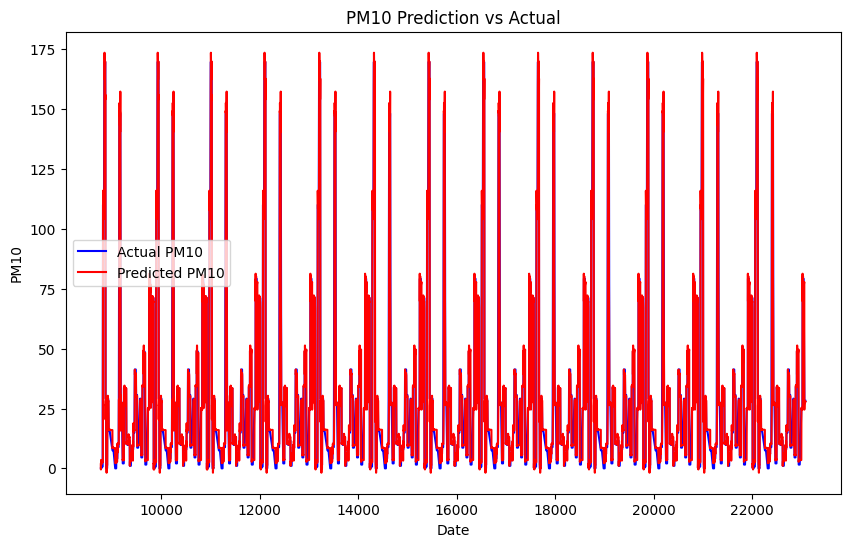

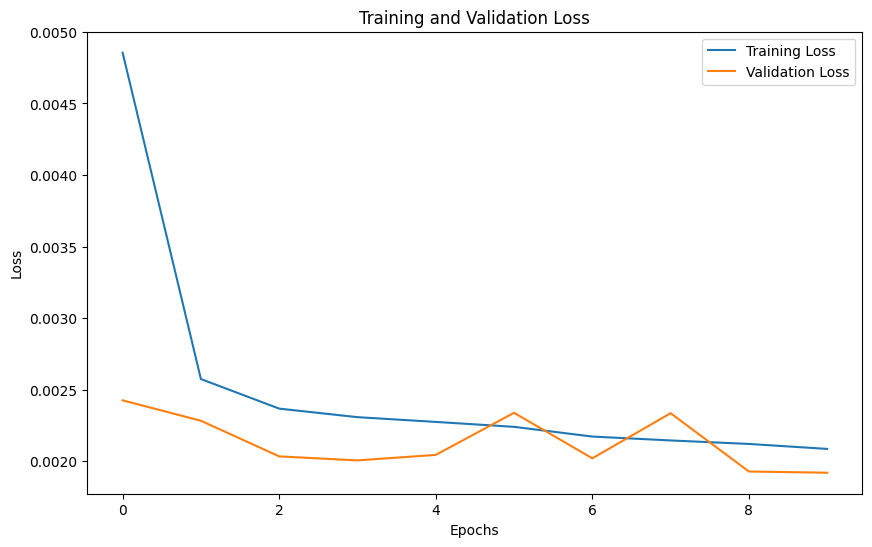

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['pm10', 'AQI', 'pm25', 'temp', 'humid', 'press']])

def create_lagged_features(data, n_lags):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_lags = 5 
X, y = create_lagged_features(scaled_data, n_lags)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 5))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 5))), axis=1))[:, 0]

rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
print(f"Root Mean Squared Error: {rmse}")

plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_original):], y_test_original, label='Actual PM10', color='blue')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted PM10', color='red')
plt.title('PM10 Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()